### 1. Imports
Import all the libraries and modules needed

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import shap

### 2. Load Dataset
Read and store the dataset in a dataframe (`df`)

In [2]:
# Load the CSV file containing student performance factors and display the first few rows of the data
df = pd.read_csv("./databases/StudentPerformanceFactors/StudentPerformanceFactors.csv")

### 3. Preprocessing

#### 3.1 Target Variable
Extract `Exam_Score` as the target vector `y`, and construct the feature matrix `X` by dropping the `Exam_Score` column from `df`.

In [3]:
# Separate features and target variable
y = df['Exam_Score']
X = df.drop(columns=['Exam_Score'])

#### 3.2 Pipeline
In this step, we define and assemble feature‐specific pipelines to handle missing values, encoding, and scaling in one unified transformer:
1. **Ordinal Pipeline**  
   - Impute missing values with the most frequent category.  
   - Encode ordered variables (`Parental_Involvement`, `Access_to_Resources`, etc.) using `OrdinalEncoder` with predefined category orders.

2. **Binary Nominal Pipeline**  
   - Impute missing values with the most frequent category.  
   - One‐hot encode true/false or binary variables (`Extracurricular_Activities`, `Internet_Access`, etc.), dropping one level to avoid redundancy.

3. **Numeric Pipeline**  
   - Impute missing values with the column mean.  
   - Standardize each numeric feature (`Hours_Studied`, `Attendance`, etc.) to zero mean and unit variance.

4. **ColumnTransformer Assembly**  
   - Combine the three pipelines into `preprocessor`, applying each to its respective column set.  
   - Also create `preprocessor_unscaled`, identical but passing numeric columns through untouched for models that require raw values.

In [4]:
# Encoding categorical features
ordinal_cols = [
    'Parental_Involvement',
    'Access_to_Resources',
    'Motivation_Level',
    'Family_Income',
    'Teacher_Quality',
    'Parental_Education_Level',
    'Distance_from_Home',
    'Peer_Influence'
]

ordinal_categories = [
    ['Low','Medium','High'],
    ['Low','Medium','High'],
    ['Low','Medium','High'],
    ['Low','Medium','High'],
    ['Low','Medium','High'],
    ['High School','College','Postgraduate'],
    ['Near','Moderate','Far'],
    ['Negative','Neutral','Positive']
]

binary_nominal_cols = [
    'Extracurricular_Activities',
    'Internet_Access',
    'Learning_Disabilities',
    'Gender',
    'School_Type'
]

numeric_cols = [
    'Hours_Studied',
    'Attendance',
    'Sleep_Hours',
    'Previous_Scores',
    'Tutoring_Sessions',
    'Physical_Activity'
]

ord_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(categories=ordinal_categories))
])

bin_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', dtype=int))
])

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('ord',   ord_pipeline,   ordinal_cols),
    ('bin',   bin_pipeline,   binary_nominal_cols),
    ('num',   num_pipeline,   numeric_cols),
])

preprocessor_unscaled = ColumnTransformer([
    ('ord',   ord_pipeline,   ordinal_cols),
    ('bin',   bin_pipeline,   binary_nominal_cols),
    ('num',   'passthrough',   numeric_cols),
])

#### 3.3 Train–Test Split
Split the feature matrix `X` and target vector `y` into training (80%) and testing (20%) subsets, using `random_state=42` to ensure reproducible results.  

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### 3.4 Preprocessor Application
Apply the defined transformers to both training and test sets by:  
1. **Scaled Data**: Fit `preprocessor` on `X_train` and transform both `X_train` and `X_test` into DataFrames (`X_train_scaled`, `X_test_scaled`) 
2. **Unscaled Data**: Fit `preprocessor_unscaled` on `X_train` and transform both splits into DataFrames (`X_train_unscaled`, `X_test_unscaled`) to retain raw numeric values alongside encoded categoricals


In [6]:
# Fit/transform scaled data and create DataFrame
X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_test_scaled = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out(), index=X_test.index)
# Fit/transform unscaled data and create DataFrame
X_train_unscaled = pd.DataFrame(preprocessor_unscaled.fit_transform(X_train), columns=preprocessor_unscaled.get_feature_names_out(), index=X_train.index)
X_test_unscaled = pd.DataFrame(preprocessor_unscaled.transform(X_test), columns=preprocessor_unscaled.get_feature_names_out(), index=X_test.index)

### 4. Linear Regression
In this step, we build and assess a linear regression model by:  
1. **Initialize and Train**: Fit `LinearRegression` on `X_train_scaled` and `y_train`.  
2. **Predict**: Generate continuous predictions for `X_test_scaled`.  
3. **Evaluate**: Calculate Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² Score to quantify regression performance.  

In [7]:
# Linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = lr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 3.24
R^2 Score: 0.77
Mean Absolute Error: 0.44


### 4.1 Linear Regression Feature Importance
Extract linear regression coefficients, compute their absolute values, and sort features by magnitude to rank their predictive influence.  

In [8]:
# Feature importance with Coefficients
importance = lr.coef_

# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': importance,
    'Abs_Importance': np.abs(importance)

})

# Sort the DataFrame by absolute importance
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False).reset_index(drop=True)

#### 4.2 Linear Regression Feature Importance Visualization
Display the top 10 features ranked by coefficient magnitude and render a horizontal bar chart of their coefficient values to highlight the most influential predictors.  

,Feature,Importance,Abs_Importance
0,num__Attendance,2.291987,2.291987
1,num__Hours_Studied,1.755734,1.755734
2,ord__Access_to_Resources,1.048347,1.048347
3,ord__Parental_Involvement,1.005249,1.005249
4,bin__Internet_Access_Yes,0.955759,0.955759
5,bin__Learning_Disabilities_Yes,-0.853972,0.853972
6,num__Previous_Scores,0.708058,0.708058
7,num__Tutoring_Sessions,0.627107,0.627107
8,bin__Extracurricular_Activities_Yes,0.577675,0.577675
9,ord__Family_Income,0.539257,0.539257


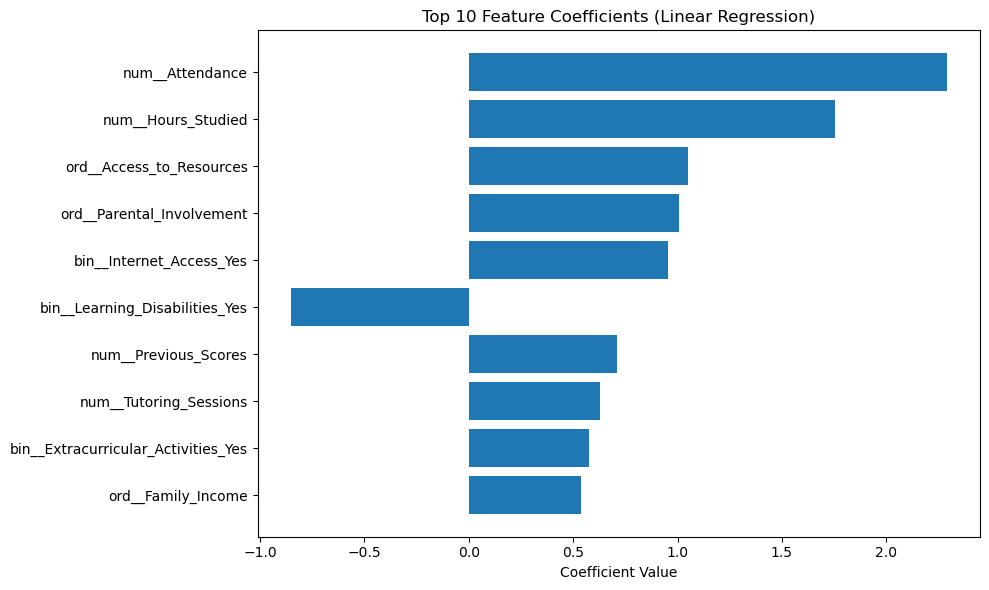

In [9]:
# Display the top 10 features
display(importance_df.head(10))
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df['Feature'].head(10)[::-1],
    importance_df['Importance'].head(10)[::-1]
)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients (Linear Regression)')
plt.tight_layout()
plt.savefig('./images/StudentPerformanceFactors/linreg_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Decision Tree
In this step, we build and assess a decision tree regressor by:  
1. **Initialize Model**: Create a `DecisionTreeRegressor` with `random_state=42`.  
2. **Train Model**: Fit the regressor on `X_train_unscaled` and `y_train`.  
3. **Make Predictions**: Generate predicted values for `X_test_unscaled`.  
4. **Evaluate Performance**: Calculate Mean Squared Error (MSE) and R² Score to quantify the model’s accuracy.

In [10]:
# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_unscaled, y_train)

# Evaluate Decision Tree
y_pred_dt = dt.predict(X_test_unscaled)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Decision Tree MSE: {mse_dt:.2f}")
print(f"Decision Tree R^2: {r2_dt:.2f}")

Decision Tree MSE: 9.90
Decision Tree R^2: 0.30


#### 5.1 Decision Tree Feature Importance
Extract the regressor’s `feature_importances_`, pair them with feature names in a DataFrame, and sort by importance to rank predictors by their mean decrease in variance.  

In [11]:
# Extract feature importances (mean decrease in variance)
dt_importances = dt.feature_importances_
dt_imp_df = pd.DataFrame({
    'Feature': X_train_unscaled.columns,
    'Importance': dt_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

#### 5.2 Decision Tree Feature Importance Visualization
Display a horizontal bar chart of the top 10 features by importance to highlight their relative influence.  

,Feature,Importance
0,num__Attendance,0.374038
1,num__Hours_Studied,0.248230
2,num__Previous_Scores,0.082855
3,ord__Parental_Involvement,0.048062
4,num__Tutoring_Sessions,0.034893
5,ord__Access_to_Resources,0.033579
6,num__Physical_Activity,0.026295
7,ord__Parental_Education_Level,0.022677
8,ord__Family_Income,0.021685
9,ord__Teacher_Quality,0.021512


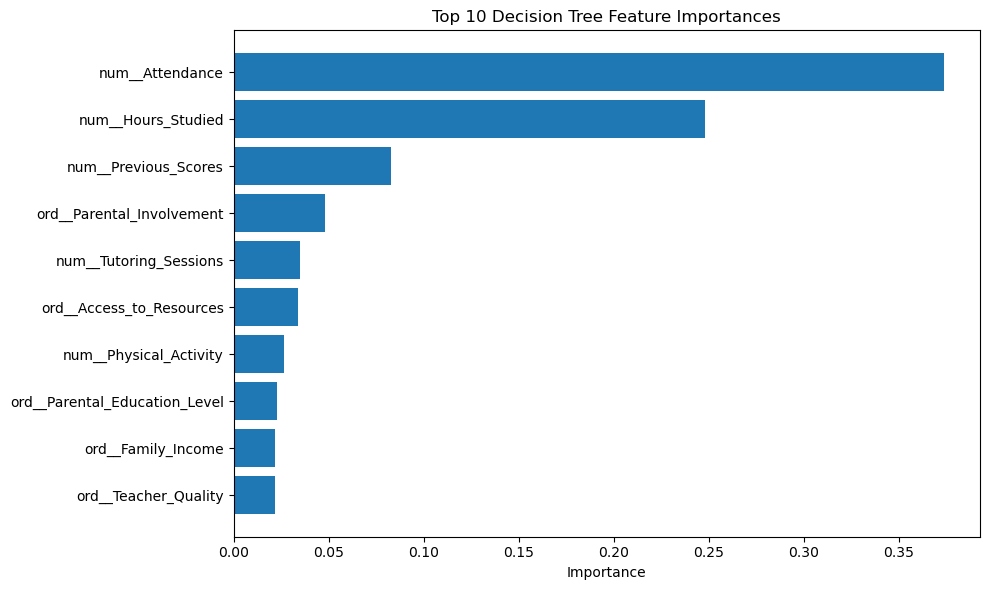

In [12]:
# Display top 10 important features
display(dt_imp_df.head(10))
# Plot Decision Tree Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(
    dt_imp_df['Feature'].head(10)[::-1],
    dt_imp_df['Importance'].head(10)[::-1]
)
plt.xlabel('Importance')
plt.title('Top 10 Decision Tree Feature Importances')
plt.tight_layout()
plt.savefig('./images/StudentPerformanceFactors/dt_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### 6. Random Forest
In this step, we build and evaluate a random forest regressor by:  
1. **Initialize Model**: Create a `RandomForestRegressor` with 100 trees and `random_state=42`.  
2. **Train Model**: Fit the regressor on `X_train_unscaled` and `y_train`.  
3. **Predict**: Generate predictions for `X_test_unscaled`.  
4. **Evaluate Performance**: Calculate Mean Squared Error (MSE) and R² Score to quantify accuracy.  

In [13]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_unscaled.values, y_train)
# Evaluate Random Forest
y_pred_rf = rf.predict(X_test_unscaled.values)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest R^2: {r2_rf:.2f}")

Random Forest MSE: 4.71
Random Forest R^2: 0.67


#### 6.1 Permutation Importance
Assess feature relevance by measuring the drop in model performance when each feature is randomly shuffled over multiple repeats, then average and rank features by their mean importance and store it in a dataframe.

In [14]:
# Permutation Importance
perm_importance = permutation_importance(
    rf, X_test_unscaled.values, y_test, n_repeats=10, random_state=42
)
perm_imp_df = pd.DataFrame({
    'Feature': X_train_unscaled.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

#### 6.2 Visualize Permutation Importance
Create a horizontal bar chart of the top 10 features ranked by their permutation importance to visualize which predictors most affect the random forest’s performance.

Top 10 Permutation Importances:


,Feature,Importance
0,num__Attendance,0.721900
1,num__Hours_Studied,0.412455
2,num__Previous_Scores,0.048020
3,ord__Access_to_Resources,0.041096
4,ord__Parental_Involvement,0.031786
5,num__Tutoring_Sessions,0.023454
6,ord__Parental_Education_Level,0.010082
7,ord__Family_Income,0.009495
8,ord__Motivation_Level,0.006938
9,ord__Peer_Influence,0.003398


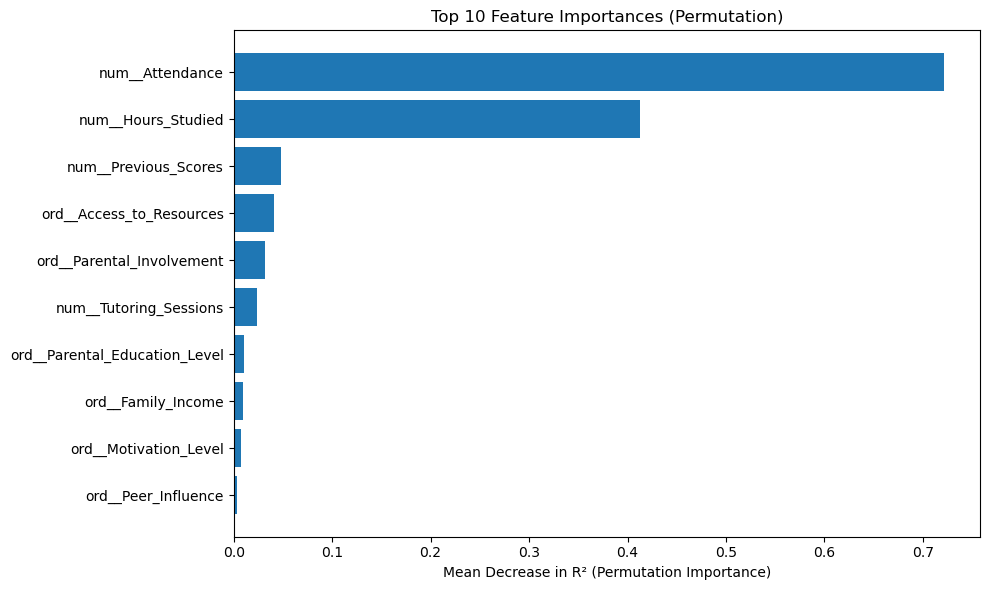

In [15]:
# Display top 10 permutation importances
print("Top 10 Permutation Importances:")
display(perm_imp_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    perm_imp_df['Feature'].head(10)[::-1],
    perm_imp_df['Importance'].head(10)[::-1]
)
plt.xlabel('Mean Decrease in R² (Permutation Importance)')
plt.title('Top 10 Feature Importances (Permutation)')
plt.tight_layout()
plt.savefig('./images/StudentPerformanceFactors/rf_permutation_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

#### 6.3 LIME
Initialize a `LimeTabularExplainer` on the random forest training data and feature names, select the i = 2 test instance, and generate a local explanation via `explain_instance()`

In [16]:
# LIME 
i = 2
explainer = LimeTabularExplainer(
    training_data=X_train_unscaled.values,
    feature_names=X_train_unscaled.columns,
    mode='regression'
)
exp = explainer.explain_instance(
    data_row=X_test_unscaled.iloc[i].values,
    predict_fn=rf.predict
)

#### 6.4 LIME Visualization
Display the local explanation for the selected test (i=2) instance as a table and a static matplotlib plot

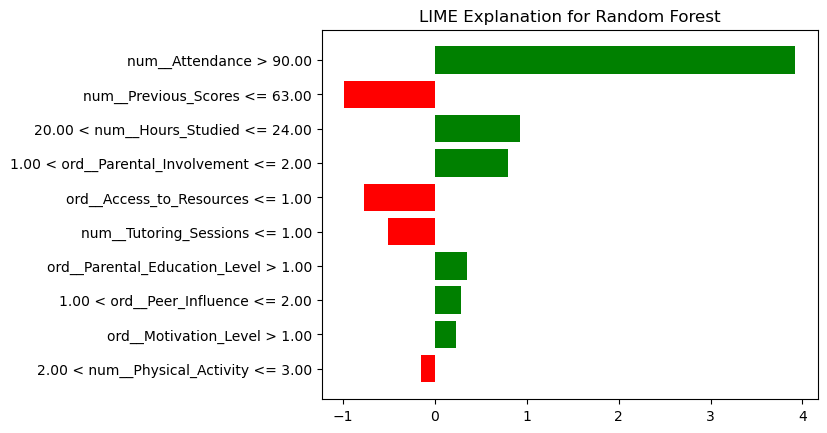

In [17]:
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

plt.title('LIME Explanation for Random Forest')
plt.savefig('./images/StudentPerformanceFactors/rf_lime_explanation.png', dpi=300, bbox_inches='tight')
plt.show()

#### 6.5 SHAP
Initialize a SHAP explainer for the random forest model and compute SHAP values for the test set (`X_test_unscaled`)

In [18]:
# SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test_unscaled)

#### 6.6 SHAP Visualization
Create a global SHAP summary bar chart showing the top 15 features ranked by their mean absolute SHAP values, then generate a local SHAP bar plot for i = 2 to illustrate individual feature contributions.  

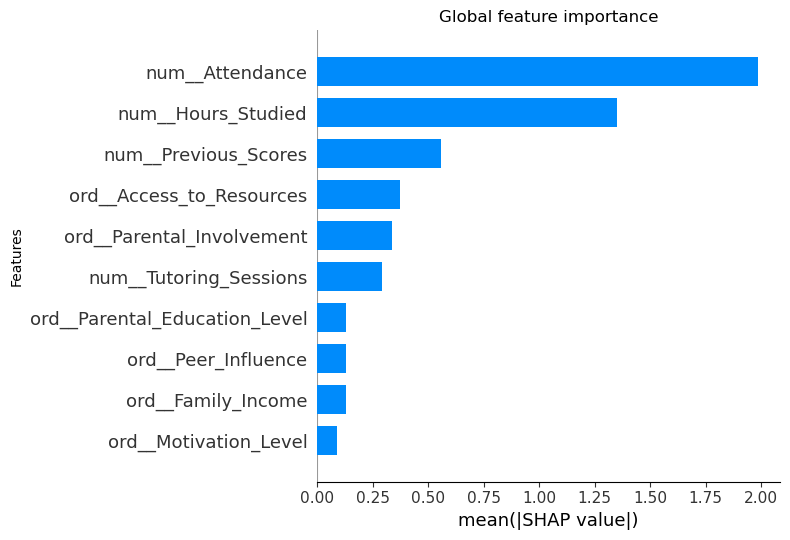

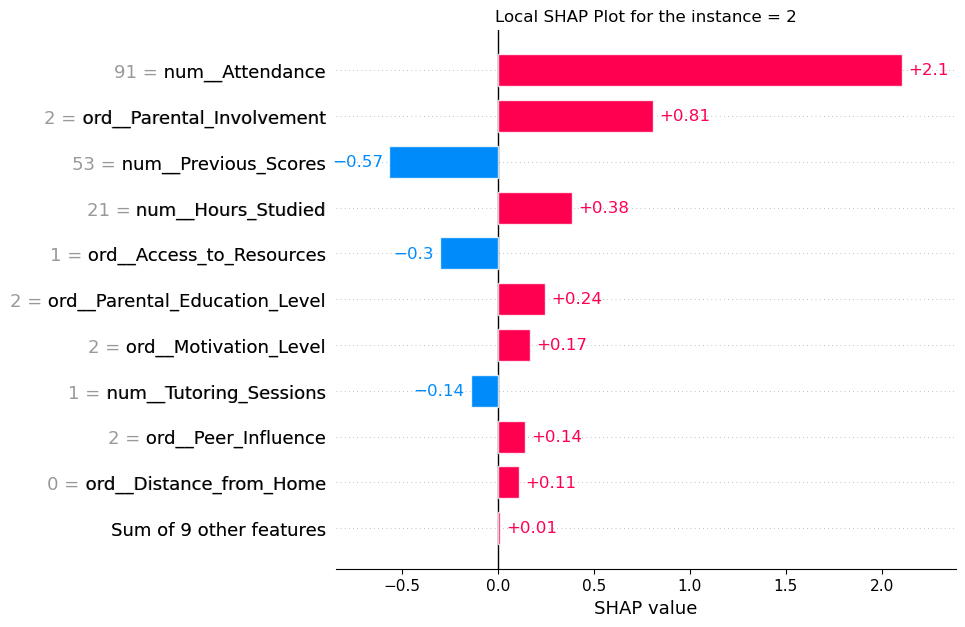

Model prediction for instance 2: 70.17


In [19]:
shap.summary_plot(shap_values, X_test_unscaled, plot_type="bar", max_display=10, show=False)
plt.title("Global feature importance")
plt.xlabel("mean(|SHAP value|)")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig('./images/StudentPerformanceFactors/rf_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

plt.title(f"Local SHAP Plot for the instance = {i}")
shap.plots.bar(shap_values[2,:], max_display=11, show=False)
plt.savefig('./images/StudentPerformanceFactors/rf_shap_local.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Model prediction for instance {i}: {y_pred_rf[i]}")

### 7. Performance Comparison
Compile MSE, RMSE, MAE, and R² for Linear Regression, Decision Tree, and Random Forest into a DataFrame for side-by-side evaluation and display the results.  

In [20]:
results = pd.DataFrame([
    {
    "Model": "Linear Regression",
    "MSE": mean_squared_error(y_test, y_pred), 
    "RMSE": root_mean_squared_error(y_test, y_pred),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
    },
    {
    "Model": "Decision Tree",
    "MSE": mean_squared_error(y_test, y_pred_dt), 
    "RMSE": root_mean_squared_error(y_test, y_pred_dt),
    "MAE": mean_absolute_error(y_test, y_pred_dt),
    "R2": r2_score(y_test, y_pred_dt)
    },
    {
    "Model": "Random Forest",
    "MSE": mean_squared_error(y_test, y_pred_rf), 
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "R2": r2_score(y_test, y_pred_rf)
    }
    ])
display(results)

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,3.237946,1.799429,0.444289,0.770928
1,Decision Tree,9.900151,3.146451,1.653555,0.299604
2,Random Forest,4.707194,2.169607,1.084531,0.666985
